In [1]:
# All imported libraries are listed herefor readbility

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from zlib import crc32



# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Transforming & Manipulating data
from sklearn.compose import ColumnTransformer


# The Linear Regression model
from sklearn.linear_model import LinearRegression



In [2]:
# Import functions from the utilities file
from TZVOLCANO_utilities import *

# Early version of chords GUI interface
from chords_gui import chords_gui 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# KMeans import

from sklearn.cluster import KMeans

In [4]:
# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [46]:
chords.select_data_file()

Available Data Files


Output()

In [47]:
# Get the selected file to use
file_name = chords.available_data_files.value
print(file_name)

# Load the data
original_data = chords.load_data_from_file(file_name)

tzvolcano_chordsrt_com_instrument_id_1_2021-02-01_to_2021-02-02.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-02-01_to_2021-02-02.csv


<AxesSubplot:xlabel='Height', ylabel='Latitude'>

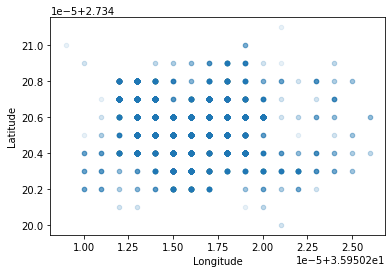

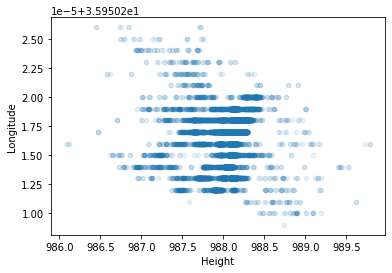

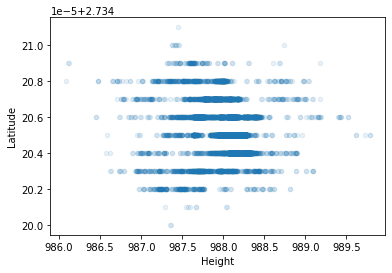

In [48]:
original_data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1)
original_data.plot(kind="scatter", x="Height", y="Longitude", alpha=0.1)
original_data.plot(kind="scatter", x="Height", y="Latitude", alpha=0.1)

In [49]:
# Calculate the seconds_since_epoch variable
original_data["seconds_since_epoch"] = original_data['Time'].astype(np.int64)

# Show all the keys (variable names) in the loaded data set
original_data.keys()

Index(['Time', 'Latitude', 'Longitude', 'Height', 'seconds_since_epoch'], dtype='object')

In [50]:
# Remove the "Time" variable from the data set, as it is not useful for the model
height_data = original_data.drop(["Time", "Longitude", "Latitude"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
print(height_data.keys())
print(type(height_data))

Index(['Height', 'seconds_since_epoch'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [51]:
# swap the order of the columns
columns_titles = ["seconds_since_epoch","Height"]
height_data=height_data.reindex(columns=columns_titles)

height_data.keys()

Index(['seconds_since_epoch', 'Height'], dtype='object')

In [52]:
# Define a pipline to clean numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler()),
])

# Test that the pipeline works
height_data_imputed = num_pipeline.fit_transform(height_data)

height_data_imputed

array([[-1.67631603,  0.22038552],
       [-1.67629631,  0.12582114],
       [-1.6762766 ,  0.24617581],
       ...,
       [ 1.7300487 , -0.02032383],
       [ 1.73006841, -0.13208174],
       [ 1.73008812, -0.1406785 ]])

<AxesSubplot:xlabel='seconds_since_epoch', ylabel='Height'>

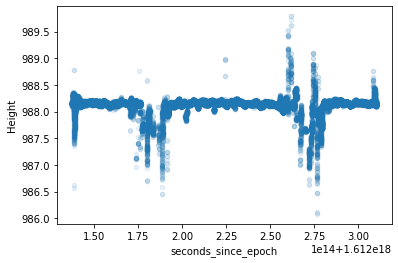

In [53]:
height_data.plot(kind="scatter", x="seconds_since_epoch", y="Height", alpha=0.1)

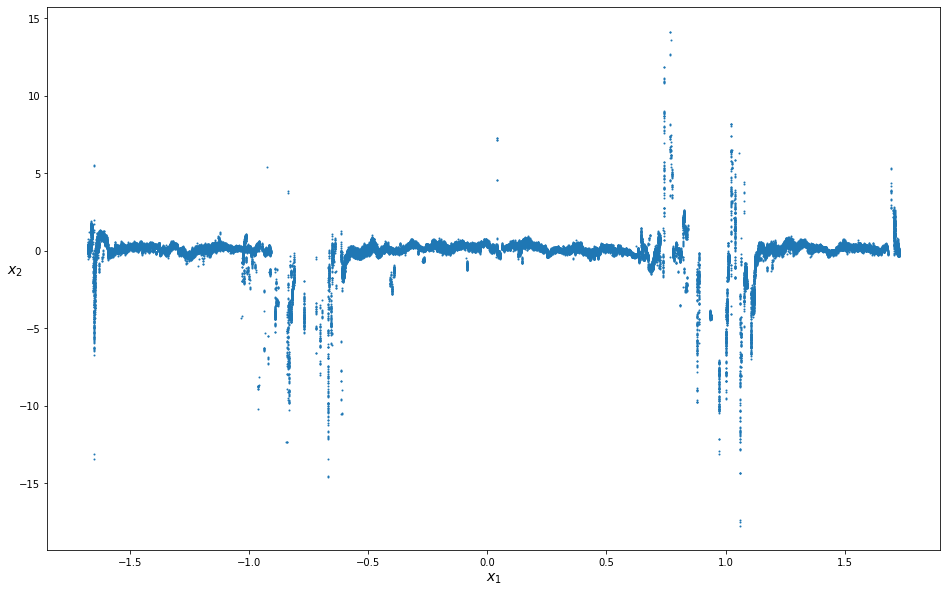

In [54]:
plt.figure(figsize=(16, 10))
plot_clusters(height_data_imputed)
plt.show()

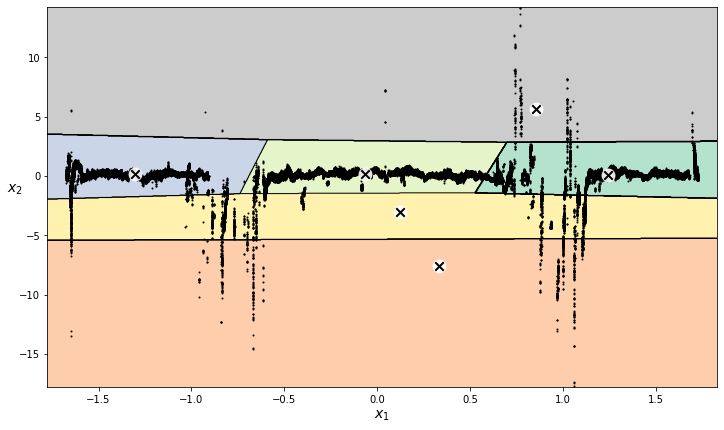

In [57]:
# Train the Kmeans model
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(height_data_imputed)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(kmeans, height_data_imputed)
plt.show()

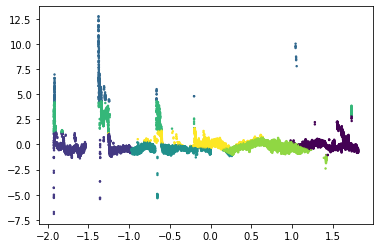

In [16]:
# Useful K-means article
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
plt.scatter(height_data_imputed[:, 0], height_data_imputed[:, 1], c=y_pred,
            s=2, cmap='viridis');

In [17]:
y_pred is kmeans.labels_

True

In [18]:
kmeans.cluster_centers_

array([[ 1.45614077,  0.07053599],
       [-1.41561809, -0.46499258],
       [-1.34522961,  5.86640459],
       [-0.52011647, -0.45757317],
       [-1.1217478 ,  2.70050119],
       [ 0.71551657, -0.17378277],
       [-0.03412161,  0.12151954]])

In [19]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [20]:
X = height_data_imputed